In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank, create_info, set_log_level, concatenate_epochs
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter
from mne.time_frequency import AverageTFR

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
set_log_level('warning')
epochs = read_epochs('ica_epo.fif')

 CSP + LDA classification

In [3]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,33
Events,left: 16right: 17
Time range,-2.000 – 7.999 sec
Baseline,off


In [4]:
lda = LinearDiscriminantAnalysis()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=34)
le = LabelEncoder()

In [5]:
freqs = [2.,7.,18.,35.,60.,90.,110.,120.,140]
freq_tags= ['2-7Hz','7-18','18-35','35-60','60-90','90-110','110-120','120-140']
freq_ranges = list(zip(freqs[:-1], freqs[1:]))

In [6]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

Classification with different time, csp and freqs

In [7]:
scores = []
time_config = [
    (1,0.2,1000,0),
    (3,0.2,300,0),
    (3,0.4,500,200),
    (3,0.4,400,200),
    (3,0.4,300,100),
]
components = [2,4,8,10,12]

In [8]:
#split training set
train_epochs = subset.get_data()
train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y, test_size=0.2)
train_epochs = concatenate_epochs(train_epochs)
test_epochs = concatenate_epochs(test_epochs)

running config 1 .
0.5714285714285714 cnf [0, 2, 3]
running config 2 ..
0.5714285714285714 cnf [1, 4, 6]
0.5714285714285714 cnf [1, 12, 6]
running config 3 ...


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464

running config 4 ....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464

running config 5 .....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464741.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\3754464

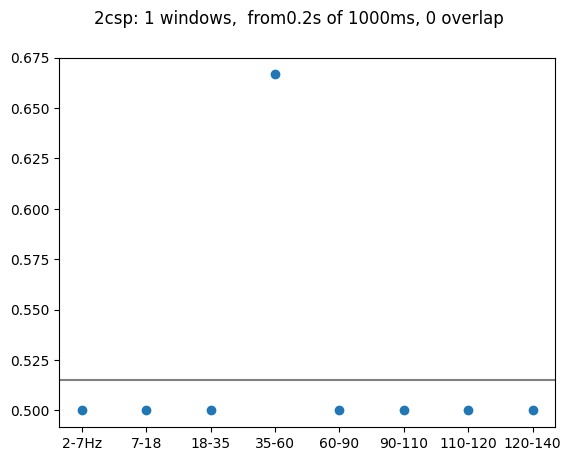

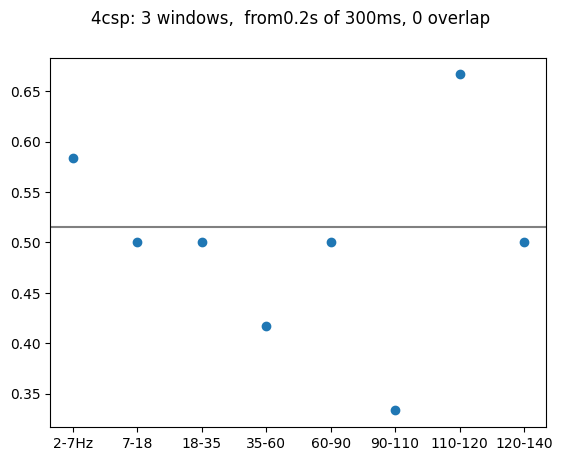

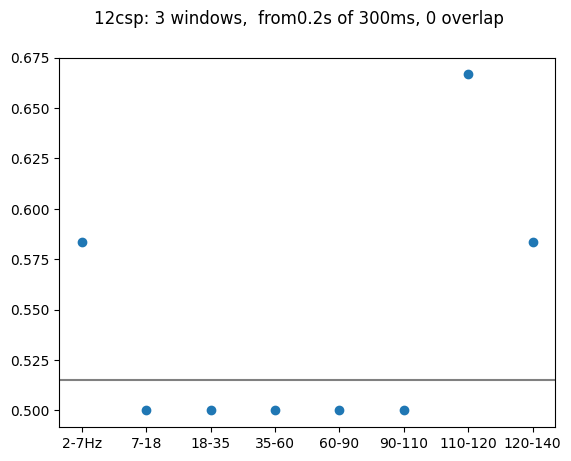

In [9]:
optimal_config = [0,0,0,0,0]
max_accuracy = 0
cnf_i = 0
best_score = 0
best_config = [0,0,0]
for cnf in time_config:
    print('running config',cnf_i+1,'.'*(cnf_i+1))
    n_windows, t_min, width, overlap = cnf
    component_score = []
    for cmp in components:
        csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')
        freq_scores = []
        for freq, (fmin, fmax) in enumerate(freq_ranges):
            X = []
            train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
            cv_split = cv.split(train_data)

            single_scr = []
            for train_idx, test_idx in cv_split:
                y_train_train, y_test_train = y_train[train_idx], y_train[test_idx]
                X_train = []
                X_test = []
                csp.fit(train_data[train_idx], y_train_train)
                w_min = 0
                for i in range(n_windows):
                    w_max = w_min + width
                    X_train.append(csp.transform(train_data[train_idx,:,w_min:w_max]))
                    X_test.append(csp.transform(train_data[test_idx,:,w_min:w_max]))
                    w_min += w_max - overlap
                    
                X_train = np.concatenate(np.array(X_train), axis=1)
                X_test = np.concatenate(np.array(X_test), axis=1)
                lda.fit(X_train, y_train_train)
                single_scr.append(lda.score(X_test, y_test_train))
            
            cv_median_score = np.median(single_scr) 
            if cv_median_score >= max_accuracy:
                max_accuracy = cv_median_score
                opt_csp = csp
                opt_lda = lda 
                optimal_config = [cnf_i,cmp,freq]
            freq_scores.append(cv_median_score)
        
        if optimal_config[0] == cnf_i and optimal_config[1] == cmp:
            X_test = []
            w_min = 0
            test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
            
            for i in range(n_windows):
                w_max = w_min + width
                X_test.append(opt_csp.transform(test_data[:,:,w_min:w_max]))
                w_min += w_max - overlap

            X_test = np.concatenate(np.array(X_test), axis=1)
            
            val_score = opt_lda.score(X_test, y_test) 
            if val_score > chance :
                if val_score > best_score:
                    best_score = val_score
                    best_config = optimal_config
                csp_fig, axes = plt.subplots(1)
                axes.scatter(freq_tags,freq_scores)
                csp_fig.suptitle('{}csp: {} windows,  from{}s of {}ms, {} overlap'.format(optimal_config[1],n_windows,t_min,width,overlap))
                axes.axhline(chance, c='grey')
                fmin, fmax = freq_ranges[optimal_config[2]]
                print(val_score, 'cnf', optimal_config)
    cnf_i += 1

In [10]:
print(best_score)
print(best_config)

0.5714285714285714
[0, 2, 3]


In [11]:
conditions = ['left','rest']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
subset

Number of events,26
Events,left: 16rest: 10
Time range,-2.000 – 7.999 sec
Baseline,off


In [12]:
subset = subset.apply_baseline((-1.4,-0.4))
y = le.fit_transform(subset.events[:,2])
chance = np.mean(y == y[0])
chance = max(chance, 1. - chance)

In [13]:
#split training set
train_epochs = subset.get_data()
train_epochs, test_epochs, y_train, y_test = train_test_split(subset, y, test_size=0.2)
train_epochs = concatenate_epochs(train_epochs)
test_epochs = concatenate_epochs(test_epochs)

running config 1 .
0.6666666666666666 cnf [0, 2, 4]
running config 2 ..
running config 3 ...


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302

running config 4 ....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302

running config 5 .....


C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302277.py:15: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
C:\Users\Alberto\AppData\Local\Temp\ipykernel_9212\1749302

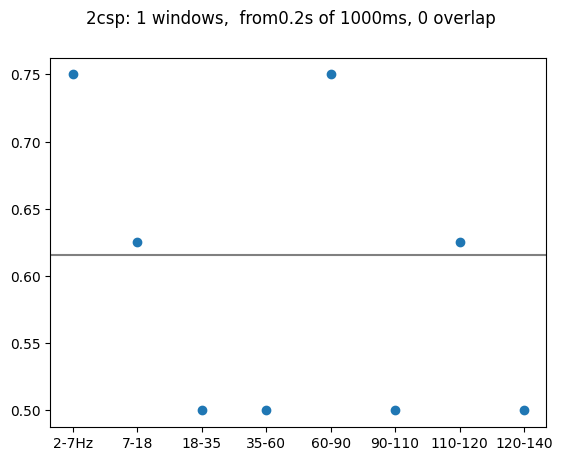

In [14]:
optimal_config = [0,0,0,0,0]
max_accuracy = 0
cnf_i = 0
best_score_0 = 0
best_config_0 = [0,0,0]
for cnf in time_config:
    print('running config',cnf_i+1,'.'*(cnf_i+1))
    n_windows, t_min, width, overlap = cnf
    component_score = []
    for cmp in components:
        csp = CSP(n_components=cmp, reg=None, log=True, norm_trace=False, rank='info')
        freq_scores = []
        for freq, (fmin, fmax) in enumerate(freq_ranges):
            X = []
            train_data = train_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
            cv_split = cv.split(train_data)

            single_scr = []
            for train_idx, test_idx in cv_split:
                y_train_train, y_test_train = y_train[train_idx], y_train[test_idx]
                X_train = []
                X_test = []
                csp.fit(train_data[train_idx], y_train_train)
                w_min = 0
                for i in range(n_windows):
                    w_max = w_min + width
                    X_train.append(csp.transform(train_data[train_idx,:,w_min:w_max]))
                    X_test.append(csp.transform(train_data[test_idx,:,w_min:w_max]))
                    w_min += w_max - overlap
                    
                X_train = np.concatenate(np.array(X_train), axis=1)
                X_test = np.concatenate(np.array(X_test), axis=1)
                lda.fit(X_train, y_train_train)
                single_scr.append(lda.score(X_test, y_test_train))
            
            cv_median_score = np.median(single_scr) 
            if cv_median_score >= max_accuracy:
                max_accuracy = cv_median_score
                opt_csp = csp
                opt_lda = lda 
                optimal_config = [cnf_i,cmp,freq]
            freq_scores.append(cv_median_score)
        
        if optimal_config[0] == cnf_i and optimal_config[1] == cmp:
            X_test = []
            w_min = 0
            test_data = test_epochs.copy().crop(t_min,1.9).filter(fmin, fmax, n_jobs=4,verbose=None).get_data()
            
            for i in range(n_windows):
                w_max = w_min + width
                X_test.append(opt_csp.transform(test_data[:,:,w_min:w_max]))
                w_min += w_max - overlap

            X_test = np.concatenate(np.array(X_test), axis=1)
            
            val_score = opt_lda.score(X_test, y_test) 
            if val_score > chance :
                if val_score > best_score_0:
                    best_score_0 = val_score
                    best_config_0 = optimal_config
                csp_fig, axes = plt.subplots(1)
                axes.scatter(freq_tags,freq_scores)
                csp_fig.suptitle('{}csp: {} windows,  from{}s of {}ms, {} overlap'.format(optimal_config[1],n_windows,t_min,width,overlap))
                axes.axhline(chance, c='grey')
                fmin, fmax = freq_ranges[optimal_config[2]]
                print(val_score, 'cnf', optimal_config)
    cnf_i += 1

In [15]:
print(best_score_0)
print(best_config_0)

0.6666666666666666
[0, 2, 4]
